## DDPG Main

### Data Preprocessing

In [142]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [143]:
print(train_df[10:])
#remove nans

                    Date  Last Price    Volume  SMAVG (15)
2331 2023-03-07 20:00:00    0.596608  0.049707    0.072420
2330 2023-03-07 20:30:00    0.606681  0.165330    0.086878
2329 2023-03-08 14:30:00    0.634154  0.134774    0.099523
2328 2023-03-08 15:00:00    0.608055  0.086473    0.077523
2327 2023-03-08 15:30:00    0.571654  0.099766    0.067301
...                  ...         ...       ...         ...
473  2023-09-29 20:30:00    0.881409  0.306496    0.180971
472  2023-10-02 14:30:00    0.794870  0.171930    0.194260
471  2023-10-02 15:00:00    0.755034  0.144825    0.184963
470  2023-10-02 15:30:00    0.762818  0.113712    0.166506
469  2023-10-02 16:00:00    0.764192  0.092697    0.157100

[1863 rows x 4 columns]


### Env

In [128]:
import gym
import numpy as np
from gym import spaces
from enum import Enum

#ignore all window size will test
# Define the Trading Environment
class DDPGTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
            super(DDPGTradingEnv, self).__init__()

            self.df = df
            self.window_size = window_size
            self.render_mode = render_mode

            #self.prices, self.signal_features = self._process_data()
            self.prices = self._process_data()
            self.shape = (window_size, self.signal_features.shape[1])
            #self.shape = self.signal_features.shape[0]

            # Define action and observation spaces
            self.action_space = spaces.Box(low=-1, high=1, hold=0, shape=(1,), dtype=np.float32)

            print(self.action_space.shape)  # This should output something like (1,)

            INF = np.inf
            self.observation_space = spaces.Box(low=-INF, high=INF, shape=self.shape, dtype=np.float32)
            self.profit_history = []  # Initialize an empty list to record profit
            # Initialize state
            self.reset()

    def reset(self):
        self.current_step = self.window_size
        #self.current_step = 1
        self.total_profit = 1.0  # Starting with unit profit
        self.history = []
        self.balance = 10000  # Example starting balance
        self.shares_held = 0
        self.portfolio_value = self.balance  # Initialize portfolio value
        self.trade_amount = 1000  # Example trade amount
        self.previous_portfolio_value = self.portfolio_value
        self.initial_balance = self.balance  # Set initial balance at the start of each episode
        return self._get_observation()

    def _process_data(self):
        # Read CSV file
        df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
        df.sort_values('Date', inplace=True)

        # Optional: Create additional features
        # df['Price Change'] = df['Last Price'].pct_change().fillna(0)

        # Normalize features
        scaler = MinMaxScaler()
        df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

        # Extract prices and features
        prices = df['Last Price'].values
        #features = df[['Last Price', 'Volume', 'SMAVG (15)']].values
        features = df[['Last Price']].values

        return prices, features

    def _get_observation(self):
        """
        Returns an observation window containing the signal features for the current step.
        """
        # Ensure the current step does not exceed the bounds of our data
        #assert self.current_step >= self.window_size

        # Get the observation window from the signal features
        start = self.current_step - self.window_size
        end = self.current_step
        observation = self.signal_features[start:end]

        return observation

    def _take_action(self, action_value):
        current_price = self.prices[self.current_step]
        if action_value > 0:
            self._buy_stock(current_price, amount=action_value)
        elif action_value < 0:
            self._sell_stock(current_price, amount=-action_value)


    def _update_portfolio(self, action_value):
        current_price = self.prices[self.current_step]
        if action_value > 0:
            self._buy_stock(current_price, amount=action_value)
        elif action_value < 0:
            self._sell_stock(current_price, amount=-action_value)
        # Update the portfolio value
        self.portfolio_value = self.balance + self.shares_held * current_price
        

    def _buy_stock(self, current_price, amount):
        # Determine the actual amount of stock to buy based on 'amount'
        # For example, you might interpret 'amount' as a percentage of your balance
        buy_amount = min(self.balance / current_price, amount)
        self.balance -= buy_amount * current_price
        self.shares_held += buy_amount

    def _sell_stock(self, current_price, amount):
        # Determine the actual amount of stock to sell based on 'amount'
        # Ensure that you don't sell more than you hold
        sell_amount = min(self.shares_held, amount)
        self.balance += sell_amount * current_price
        self.shares_held -= sell_amount


    """def step(self, action):
        print(f"Received action in step: {action}")
        action_value = action[0]
        # Debugging: print the type and value of action
        print(f"Action type: {type(action)}, Action value: {action}")

        # Assuming action is a float
        action_value = action  # No need for indexing

        # Now pass action_value to _take_action and the rest of the code
        self._take_action(action_value)

        # Advance the current step
        self.current_step += 1

        # Calculate reward
        reward = self._calculate_reward(action)

        # Check if the end of the data is reached
        done = self.current_step >= len(self.prices) - 1

        # Get the next observation
        observation = self._get_observation()

        # Additional information, useful for debugging
        info = {'current_step': self.current_step, 'total_profit': self.total_profit}
        reward = self._calculate_reward(action)
        self.profit_history.append(self.total_profit)  # Record profit
        return observation, reward, done, info"""
    def step(self, action):
        action_value = action.item()  # Extract the single value from the array
        self._take_action(action_value)
        self.current_step += 1
        reward = self._calculate_reward(action_value)
        done = self.current_step >= len(self.prices) - 1
        observation = self._get_observation()
        info = {'current_step': self.current_step, 'total_profit': self.total_profit}
        self.profit_history.append(self.total_profit)  # Record 
        print(f"Step: ",self.current_step,". Portfolio value: ",self.portfolio_value)
        return observation, reward, done, info

    def render(self, mode='human'):
        # Simple text rendering
        if mode == 'human':
            print(f"Step: {self.current_step}, Total Profit: {self.total_profit}")

    def _calculate_reward(self, action):
        """
        Calculate the reward based on the action taken.
        Action can either be buying or selling a stock.
        The reward is the change in portfolio value as a result of the action.
        """
        # Assuming self.portfolio_value stores the current value of the portfolio
        previous_portfolio_value = self.portfolio_value

        # Update portfolio value based on the action
        self._update_portfolio(action)

        # New portfolio value
        current_portfolio_value = self.portfolio_value

        # Reward is the change in portfolio value
        reward = current_portfolio_value - previous_portfolio_value

        self._update_portfolio(action)  # Ensure this method updates the portfolio value
        current_portfolio_value = self.portfolio_value
        reward = current_portfolio_value - self.previous_portfolio_value
        self.previous_portfolio_value = current_portfolio_value
        self._update_profit(action)
        return reward

    def _update_profit(self, action):
        """
        Update the total profit based on the action taken.
        """
        current_price = self.prices[self.current_step]

        # Update the portfolio after the action
        self._update_portfolio(action)

        # Calculate total profit as the difference between current portfolio value and initial balance
        self.total_profit = self.portfolio_value - self.initial_balance
        # Print for debugging
        print(f"Updated total profit: {self.total_profit}")



In [145]:
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
window_size=1
# Assuming your environment is already defined as `env`
env = DDPGTradingEnv(df, window_size)
# Add some noise for exploration
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize DDPG model
ddpg_model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)

# Train the model
total_timesteps = 10000  # Set the total number of timesteps to train for
ddpg_model.learn(total_timesteps=total_timesteps)

# Reset the environment before running the model


# Run the model on the entire dataset
"""for i in range(total_timesteps):
    action, _states = ddpg_model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)

    # Optional: Log results
    print(f"Step: {i}, Reward: {rewards}, Total Profit: {info['total_profit']}")

    if done:
        obs = env.reset()"""


(1,)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Updated total profit: 0.0
Step:  2 . Portfolio value:  10000.0
Updated total profit: 0.0
Step:  3 . Portfolio value:  10000.0
Updated total profit: 0.001215939339090255
Step:  4 . Portfolio value:  10000.001215939339
Updated total profit: 0.012682524997217115
Step:  5 . Portfolio value:  10000.012682524997
Updated total profit: -0.004292305142371333
Step:  6 . Portfolio value:  9999.995707694858
Updated total profit: -0.014538635516146314
Step:  7 . Portfolio value:  9999.985461364484
Updated total profit: -0.01696001778327627
Step:  8 . Portfolio value:  9999.983039982217
Updated total profit: 0.036007074730150634
Step:  9 . Portfolio value:  10000.03600707473
Updated total profit: 0.04153252338983293
Step:  10 . Portfolio value:  10000.04153252339
Updated total profit: -0.01636237200909818
Step:  11 . Portfolio value:  9999.98363762799
Updated total profit: 0.09308049846731592
Step:  12

C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\rohit\AppData\Local\Temp\ipykernel_17140\2094677146.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  buy_amount = min(self.balance / current_price, amount)


Updated total profit: 60.45843737134419
Step:  501 . Portfolio value:  10060.458437371344
Updated total profit: 57.61272485611153
Step:  502 . Portfolio value:  10057.612724856112
Updated total profit: 55.91190240529977
Step:  503 . Portfolio value:  10055.9119024053
Updated total profit: 53.46647513881362
Step:  504 . Portfolio value:  10053.466475138814
Updated total profit: 57.1832243382305
Step:  505 . Portfolio value:  10057.18322433823
Updated total profit: 52.66770988275857
Step:  506 . Portfolio value:  10052.667709882759
Updated total profit: 37.73154332313425
Step:  507 . Portfolio value:  10037.731543323134
Updated total profit: 35.63223121638657
Step:  508 . Portfolio value:  10035.632231216387
Updated total profit: 30.228734513204472
Step:  509 . Portfolio value:  10030.228734513204
Updated total profit: 28.79287966152515
Step:  510 . Portfolio value:  10028.792879661525
Updated total profit: 27.112421490162887
Step:  511 . Portfolio value:  10027.112421490163
Updated tota

'for i in range(total_timesteps):\n    action, _states = ddpg_model.predict(obs, deterministic=True)\n    obs, rewards, done, info = env.step(action)\n\n    # Optional: Log results\n    print(f"Step: {i}, Reward: {rewards}, Total Profit: {info[\'total_profit\']}")\n\n    if done:\n        obs = env.reset()'

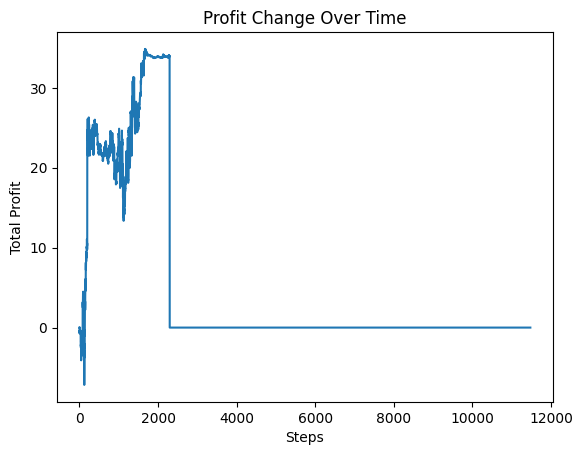

In [130]:
import matplotlib.pyplot as plt

# Plotting the profit change
plt.plot(env.profit_history)
plt.title("Profit Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Total Profit")
plt.show()

In [108]:
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

# Define your DDPGTradingEnv class here

# Initialize the environment
env = DDPGTradingEnv(df, window_size, render_mode=False)

# Determine the number of actions
n_actions = env.action_space.shape[-1]

# Define the action noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize the DDPG model
ddpg_model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)

test_action = np.array([0.5])  # Sample action
observation, reward, done, info = env.step(test_action)

# Proceed with training and other operations
#ddpg_model.learn(total_timesteps=10000)


(1,)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Updated portfolio. Portfolio value: 9999.99496332384
Updated portfolio. Portfolio value: 9999.99496332384
Updated portfolio. Portfolio value: 9999.994963323838
Updated total profit: -0.005036676162490039


C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [131]:
obs = env.reset()
for i in range(1000):
    action, _states = ddpg_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()

Updated total profit: 0.0
Step:  61 . Portfolio value:  10000.0
Step: 61, Total Profit: 0.0
Updated total profit: 0.0
Step:  62 . Portfolio value:  10000.0
Step: 62, Total Profit: 0.0
Updated total profit: 0.0
Step:  63 . Portfolio value:  10000.0
Step: 63, Total Profit: 0.0
Updated total profit: 0.0
Step:  64 . Portfolio value:  10000.0
Step: 64, Total Profit: 0.0
Updated total profit: 0.0
Step:  65 . Portfolio value:  10000.0
Step: 65, Total Profit: 0.0
Updated total profit: 0.0
Step:  66 . Portfolio value:  10000.0
Step: 66, Total Profit: 0.0
Updated total profit: 0.0
Step:  67 . Portfolio value:  10000.0
Step: 67, Total Profit: 0.0
Updated total profit: 0.0
Step:  68 . Portfolio value:  10000.0
Step: 68, Total Profit: 0.0
Updated total profit: 0.0
Step:  69 . Portfolio value:  10000.0
Step: 69, Total Profit: 0.0
Updated total profit: 0.0
Step:  70 . Portfolio value:  10000.0
Step: 70, Total Profit: 0.0
Updated total profit: 0.0
Step:  71 . Portfolio value:  10000.0
Step: 71, Total 